In [48]:
import pandas as pd
import numpy as np

from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import lightning as L

from matplotlib import pyplot as plt

import cv2
import os

from torchvision.transforms import v2
import torchvision
from torchvision.models import resnet50

import PIL

from tqdm import tqdm
from sklearn.metrics import accuracy_score

# Prepare data

In [2]:
meta = pd.read_csv("../stanford_dataset/stanford_cars_type.csv", index_col=0)
meta

,file_name,car_code,car_name,brand,car_type,new_filename
0,00001.jpg,14,Audi TTS Coupe 2012,Audi,Coupe,00001_Audi TTS Coupe 2012.jpg
1,00002.jpg,3,Acura TL Sedan 2012,Acura,Sedan,00002_Acura TL Sedan 2012.jpg
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Dodge,Cab,00003_Dodge Dakota Club Cab 2007.jpg
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Hyundai,Sedan,00004_Hyundai Sonata Hybrid Sedan 2012.jpg
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Ford,Cab,00005_Ford F-450 Super Duty Crew Cab 2012.jpg
...,...,...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Chrysler,Minivan,08140_Chrysler Town and Country Minivan 2012.jpg
8140,08141.jpg,196,smart fortwo Convertible 2012,smart,Convertible,08141_smart fortwo Convertible 2012.jpg
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Mercedes-Benz,Coupe,08142_Mercedes-Benz SL-Class Coupe 2009.jpg
8142,08143.jpg,112,Ford GT Coupe 2006,Ford,Coupe,08143_Ford GT Coupe 2006.jpg


In [3]:
np.random.seed(42)
train_share = 0.8
train_test_mask = np.random.rand(len(meta)) < train_share
meta.loc[train_test_mask, 'learning_label'] = 'Train'
meta.loc[~train_test_mask, 'learning_label'] = 'Test'

In [4]:
meta.query("learning_label == 'Train'")

,file_name,car_code,car_name,brand,car_type,new_filename,learning_label
0,00001.jpg,14,Audi TTS Coupe 2012,Audi,Coupe,00001_Audi TTS Coupe 2012.jpg,Train
2,00003.jpg,91,Dodge Dakota Club Cab 2007,Dodge,Cab,00003_Dodge Dakota Club Cab 2007.jpg,Train
3,00004.jpg,134,Hyundai Sonata Hybrid Sedan 2012,Hyundai,Sedan,00004_Hyundai Sonata Hybrid Sedan 2012.jpg,Train
4,00005.jpg,106,Ford F-450 Super Duty Crew Cab 2012,Ford,Cab,00005_Ford F-450 Super Duty Crew Cab 2012.jpg,Train
5,00006.jpg,123,Geo Metro Convertible 1993,Geo,Convertible,00006_Geo Metro Convertible 1993.jpg,Train
...,...,...,...,...,...,...,...
8139,08140.jpg,78,Chrysler Town and Country Minivan 2012,Chrysler,Minivan,08140_Chrysler Town and Country Minivan 2012.jpg,Train
8140,08141.jpg,196,smart fortwo Convertible 2012,smart,Convertible,08141_smart fortwo Convertible 2012.jpg,Train
8141,08142.jpg,163,Mercedes-Benz SL-Class Coupe 2009,Mercedes-Benz,Coupe,08142_Mercedes-Benz SL-Class Coupe 2009.jpg,Train
8142,08143.jpg,112,Ford GT Coupe 2006,Ford,Coupe,08143_Ford GT Coupe 2006.jpg,Train


In [5]:
car_type_mappa = {'Coupe': 0,
 'Sedan': 1,
 'Cab': 2,
 'Convertible': 3,
 'SUV': 4,
 'Minivan': 5,
 'Hatchback': 6,
 'Other': 7,
 'Van': 8,
 'Wagon': 9}

inverse_mappa = dict(zip(car_type_mappa.values(), car_type_mappa.keys()))

In [6]:
class CarDataset(Dataset):
    def __init__(self, root_dir: str, frame: pd.DataFrame, transform=None):
        self.frame = frame
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return self.frame.shape[0]
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.frame.iloc[idx, -3],
                                self.frame.iloc[idx, -2])
        
        image = cv2.imread(img_name)
        label = car_type_mappa[self.frame.iloc[idx, -3]]
        sample = {'image': image, 'label': label}

        if self.transform:
            image = self.transform(image)
            sample['image'] = image

        return sample

In [7]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(224, 224)),
    # v2.RandomResizedCrop(size=(224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.ToTensor(),
    v2.Resize(size=(224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

C:\Users\nnprazdnikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
train_dataset = CarDataset("../stanford_dataset/stanford_cars_type/", meta.query("learning_label == 'Train'"), transforms)
test_dataset = CarDataset("../stanford_dataset/stanford_cars_type/", meta.query("learning_label == 'Test'"), test_transforms)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


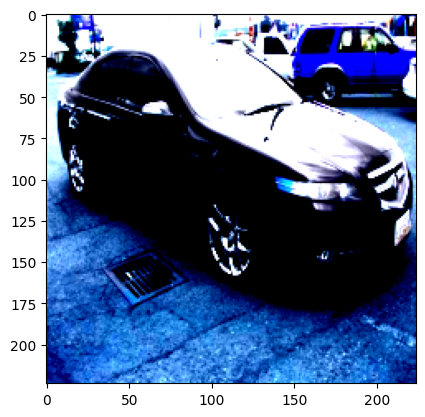

'Coupe'

In [9]:
img = train_dataset[1000]["image"]
img = np.swapaxes(img, 0, 2)
img = np.swapaxes(img, 1, 0)
plt.imshow(img)
plt.show()
inverse_mappa[train_dataset[0]["label"]]

# BaseLine Model

In [10]:
model = resnet50(weights='DEFAULT')

In [11]:
num_classes = 10

In [ ]:
## freeze
#for param in model.parameters():
#    param.requires_grad = False

In [12]:
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [13]:
class Module(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
        self.train_loss_ttl = list()
        self.val_loss_ttl = list()

        self.train_loss_epoch = list()
        self.val_loss_epoch = list()

    def forward(self, x):
        result = self.model(x)
        return result

    def inverse_forward(self, x):
        self.eval()
        with torch.no_grad():
            return scaler_train.inverse_transform(self.model(x))
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters())
        return optimizer

    def training_step(self, train_batch, batch_idx):
        X, y = train_batch['image'], train_batch['label']
        y_hat = self.model(X)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(y_hat, y)
        self.log('train_loss', loss, prog_bar=True)
        self.train_loss_epoch.append(loss.cpu().detach().numpy())
        return loss

    def validation_step(self, val_batch, batch_idx):
        X, y = val_batch['image'], val_batch['label']
        y_hat = self.model(X)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(y_hat, y)
        self.log('test_loss', loss, prog_bar=True)
        self.val_loss_epoch.append(loss.cpu().detach().numpy())

# Train

In [14]:
next(iter(train_loader))['label']

tensor([3, 4, 4, 0, 1, 9, 1, 7, 7, 0, 0, 1, 7, 6, 1, 7, 2, 0, 3, 4, 6, 7, 6, 0,
        3, 2, 3, 3, 0, 0, 0, 0])

In [49]:
module = Module(model)

trainer = L.Trainer(max_epochs=15)
trainer.fit(model=module, train_dataloaders=train_loader, val_dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 23.5 M
---------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: |                                                                               | 0/? [00:00<?, ?it/s]

C:\Users\nnprazdnikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


C:\Users\nnprazdnikov\AppData\Local\Programs\Python\Python312\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 0: 100%|████████████████████████████████████████████| 204/204 [34:29<00:00,  0.10it/s, v_num=8, train_loss=2.110]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████| 204/204 [26:12<00:00,  0.13it/s, v_num=8, train_loss=2.080, test_loss=2.100]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████| 204/204 [20:14<00:00,  0.17it/s, v_num=8, train_loss=2.370, test_loss=2.100]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|███████████████████████████| 204/204 [24:45<00:00,  0.14it/s, v_num=8, train_loss=2.060, test_loss=2.080]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████████████████████

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|███████████████████████████| 204/204 [30:56<00:00,  0.11it/s, v_num=8, train_loss=2.060, test_loss=2.090]


# Validation

In [50]:
prediction = list()
true = list()

for batch in tqdm(test_loader):
    model.eval()

    with torch.no_grad():
        X, y = batch['image'], batch['label']
        pred = model(X)
        true.append(y)
        prediction.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [02:37<00:00,  3.09s/it]


In [51]:
true_list = list()
for i in true:
    true_list += i.tolist()

prediction_list = list()
for i in prediction:
    _, indices = torch.max(i, 1)
    prediction_list += indices
prediction_list = list(map(int, prediction_list))

In [52]:
accuracy_score(true_list[:len(prediction_list)], prediction_list)

0.22558714462299134